<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Download-data" data-toc-modified-id="Download-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Download data</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Train/test-split-&amp;-CV-strategy" data-toc-modified-id="Train/test-split-&amp;-CV-strategy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train/test split &amp; CV strategy</a></span></li><li><span><a href="#Boosting-depth-(n_estimators)" data-toc-modified-id="Boosting-depth-(n_estimators)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Boosting depth (n_estimators)</a></span></li><li><span><a href="#GridSearchCV" data-toc-modified-id="GridSearchCV-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>GridSearchCV</a></span></li><li><span><a href="#Evaluation-on-held-out-dataset" data-toc-modified-id="Evaluation-on-held-out-dataset-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluation on held out dataset</a></span></li><li><span><a href="#SHAP" data-toc-modified-id="SHAP-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>SHAP</a></span></li></ul></div>

# Imports

In [20]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import lightgbm as lgb
from shap import TreeExplainer, summary_plot, Explanation
from shap.plots import scatter, bar, beeswarm

# Download data

In [2]:
data = pd.read_csv('data_test.csv', sep="\t")
data.sort_values('timestamp_minutes5', inplace=True)

In [3]:
anomaly = pd.read_csv('anomaly.csv', sep="\t")
anomaly['anomaly'] = 1
anomaly = anomaly.drop_duplicates()
out = pd.merge(data, anomaly, how="left").fillna(0)
out['timestamp_minutes5'] = pd.to_datetime(out['timestamp_minutes5'], unit='s')
out['dupe'] = out.groupby('timestamp_minutes5')['anomaly'].transform(lambda x: len(x)>1)
out.insert(0,'id', range(len(out)))
out.rename(columns={'timestamp_minutes5':'time'}, inplace=True)


out['minute'] = out['time'].dt.minute
out['hour'] = out['time'].dt.hour
out['wday'] = out['time'].dt.day_of_week
std = out['sum_count'].std()
mn = out['sum_count'].mean()
out['ewa'] = out['sum_count'].ewm(span=20, min_periods=0, adjust=False, ignore_na=False).mean()
out['diff'] = (out['sum_count'] - out['ewa'])/std
for i in [1,2,3,4,5,6]:
    out[f'diff_{i*5}_min'] = (out['sum_count'] - out['sum_count'].shift(i).fillna(mn))/std

In [4]:
out.set_index('time', inplace=True)

In [5]:
out

,id,sum_count,anomaly,dupe,minute,hour,wday,ewa,diff,diff_5_min,diff_10_min,diff_15_min,diff_20_min,diff_25_min,diff_30_min
time,,,,,,,,,,,,,,,
2019-05-31 21:00:00,0,31466984.0,0.0,False,0,21,4,3.146698e+07,0.000000,1.159236,1.159236,1.159236,1.159236,1.159236,1.159236
2019-05-31 21:05:00,1,29108251.0,0.0,False,5,21,4,3.124234e+07,-0.248718,-0.274898,0.884338,0.884338,0.884338,0.884338,0.884338
2019-05-31 21:10:00,2,28475443.0,0.0,False,10,21,4,3.097883e+07,-0.291757,-0.073751,-0.348649,0.810587,0.810587,0.810587,0.810587
2019-05-31 21:15:00,3,27278641.0,0.0,False,15,21,4,3.062643e+07,-0.390168,-0.139481,-0.213232,-0.488130,0.671106,0.671106,0.671106
2019-05-31 21:20:00,4,26539619.0,0.0,False,20,21,4,3.023721e+07,-0.430936,-0.086129,-0.225611,-0.299361,-0.574260,0.584977,0.584977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26 20:40:00,7509,20434609.0,0.0,False,40,20,2,2.342923e+07,-0.349008,-0.052226,-0.142790,-0.148877,-0.241626,-0.307732,-0.353703
2019-06-26 20:45:00,7510,19372421.0,0.0,False,45,20,2,2.304287e+07,-0.427772,-0.123793,-0.176018,-0.266582,-0.272670,-0.365419,-0.431524
2019-06-26 20:50:00,7511,18895175.0,0.0,False,50,20,2,2.264785e+07,-0.437355,-0.055621,-0.179413,-0.231639,-0.322203,-0.328291,-0.421040


In [6]:
for t in out.index:
    try:
        val= out.loc[t - pd.Timedelta(hours=24)]['sum_count'].max()
    except:
        val = mn
    out.loc[t,'diff_24_h'] = (val - out.loc[t,'sum_count'])/std

# Train/test split & CV strategy

In [7]:
y = out.pop('anomaly')
idx = out.pop('id')
X = out.copy()

N = 5000
X_train = X[:N]
X_test = X[N:]
y_train = y[:N]
y_test = y[N:]
idx_train = idx[:N]
idx_test = idx[N:]

cv = TimeSeriesSplit(n_splits=3)

# Boosting depth (n_estimators)

In [10]:
params={
    "objective":"binary",
    "max_depth":5,
    "learning_rate":.03,
    "verbose": 100,
    "n_estimators":1000
}
d_train = lgb.Dataset(data=X_train, label=y_train)
hist= lgb.cv(params,d_train, metrics="binary_logloss", early_stopping_rounds=50)

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 77, number of negative: 3923
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.022815
[LightGBM] [Debug] init for col-wise cost 0.000022 seconds, init for row-wise cost 0.000672 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2595
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 14
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set nu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 9 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 5
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Warning]

In [11]:
len(hist['binary_logloss-mean'])

207

# GridSearchCV

In [12]:
param_grid = {
    "max_depth":[2,3,4],
    "colsample_bytree":[.6,.7,.8],
    "subsample":[.7,.8,.9],
    "min_data_in_leaf": [4, 8,16],
    "num_leaves": [2,4,16]
}
mod = lgb.sklearn.LGBMClassifier(n_estimators=300, objective='binary', metrics='binary_logloss', random_state=42, device='gpu')
gs = GridSearchCV(mod, param_grid, cv=cv, refit=True)
gs.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMClassifier(device='gpu', metrics='binary_logloss',
                                      n_estimators=300, objective='binary',
                                      random_state=42),
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8],
                         'max_depth': [2, 3, 4], 'min_data_in_leaf': [4, 8, 16],
                         'num_leaves': [2, 4, 16],
                         'subsample': [0.7, 0.8, 0.9]})

In [13]:
gs.best_score_
# 0.9944000000000001

0.9944000000000001

In [14]:
gs.best_params_
# {'colsample_bytree': 0.7,
#  'device': 'gpu',
#  'max_depth': 3,
#  'min_data_in_leaf': 8,
#  'num_leaves': 4,
#  'subsample': 0.9}

{'colsample_bytree': 0.6,
 'max_depth': 3,
 'min_data_in_leaf': 4,
 'num_leaves': 4,
 'subsample': 0.7}

# Evaluation on held out dataset

In [15]:
model = gs.best_estimator_
preds = model.predict(X_test)
(preds==y_test).mean()

0.9976133651551312

In [16]:
X_train.columns

Index(['sum_count', 'dupe', 'minute', 'hour', 'wday', 'ewa', 'diff',
       'diff_5_min', 'diff_10_min', 'diff_15_min', 'diff_20_min',
       'diff_25_min', 'diff_30_min', 'diff_24_h'],
      dtype='object')

# SHAP

In [17]:
explainer = TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


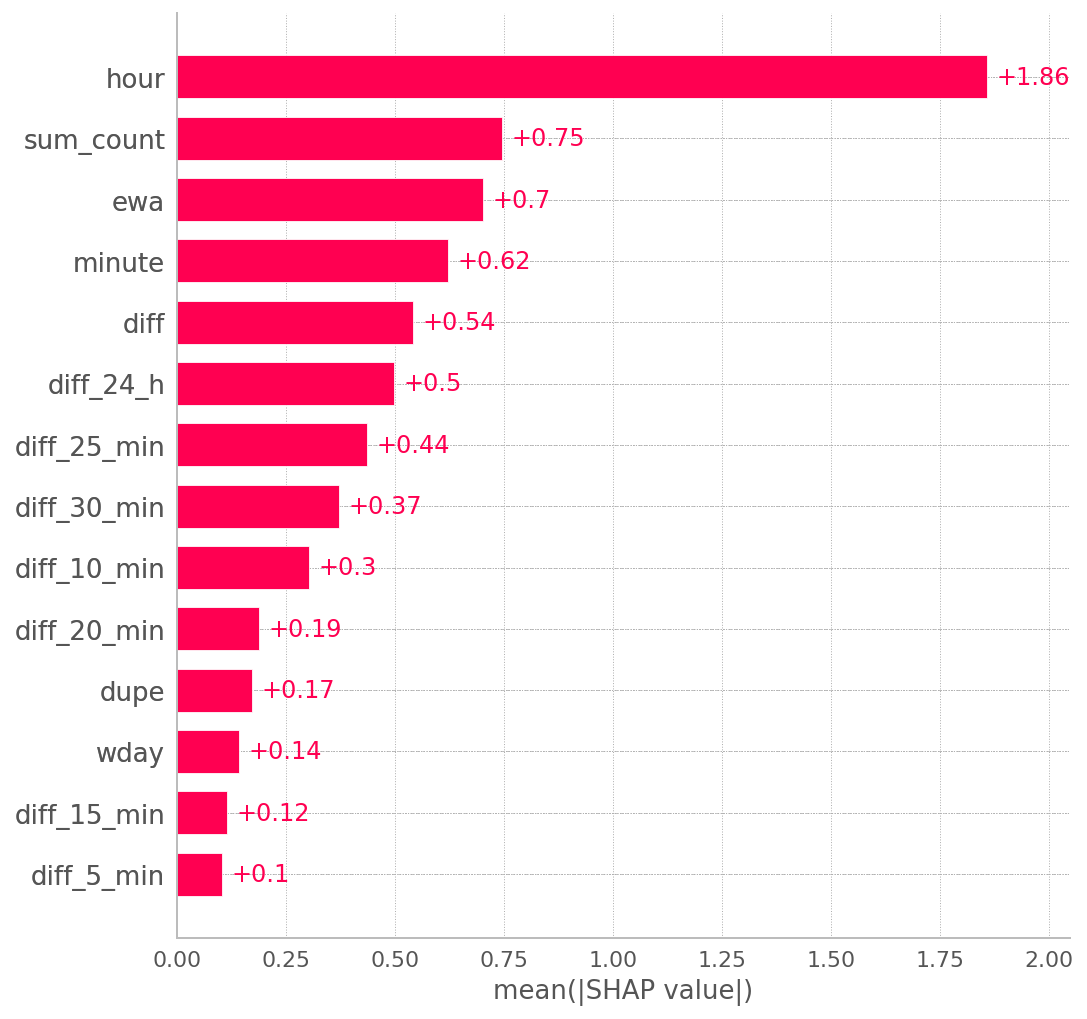

In [18]:
sv = Explanation(values=shap_values[1], data=X_train.values, feature_names=X_train.columns)
bar(sv, max_display=15)

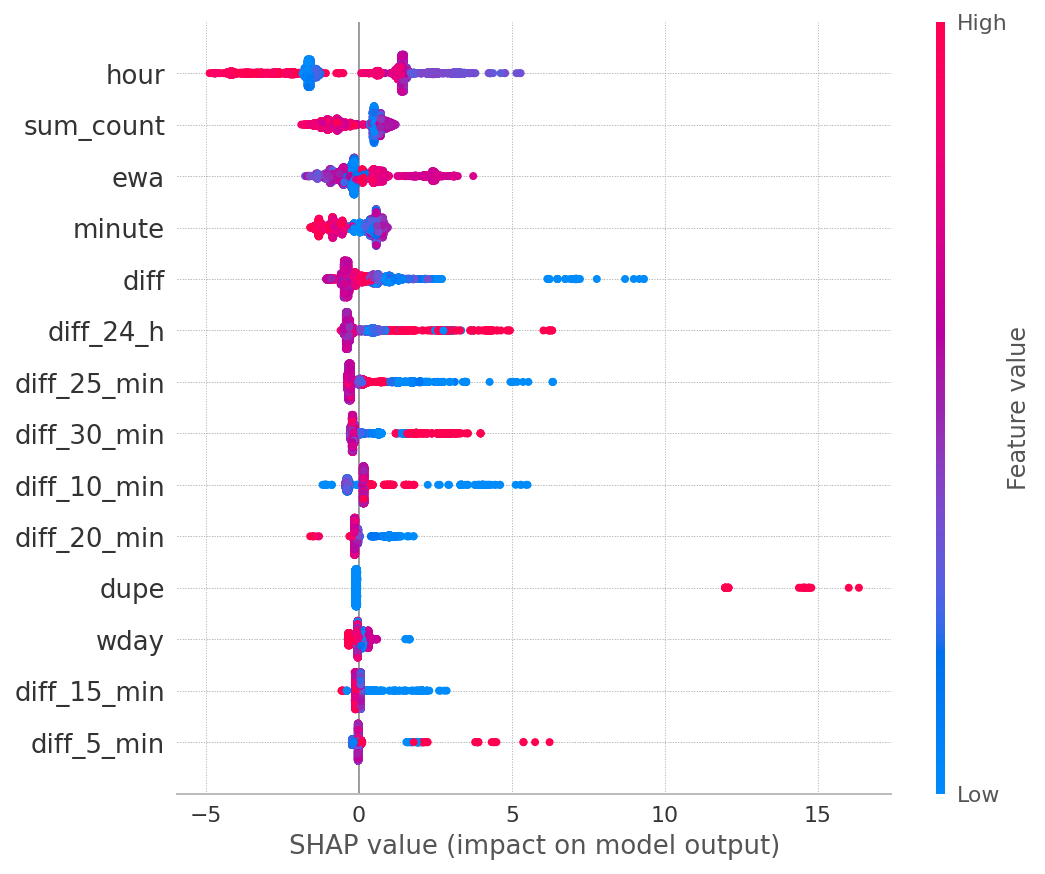

In [21]:
beeswarm(sv,max_display=15)

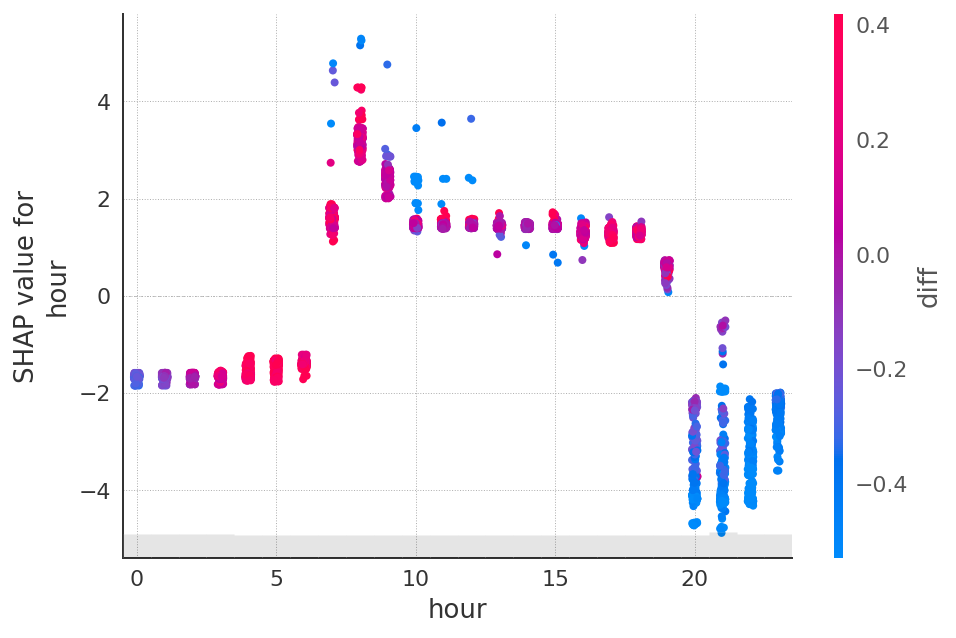

In [22]:
scatter(sv[:,3], color=sv)